# 6-7 多类别分类：一对多
这个部分需要实现手写数字（0到9）的识别。需要扩展之前的逻辑回归，并将其应用于一对多的分类。

数据集是一个MATLAB格式的.m文件，其中包含5000个20*20像素的手写字体图像，以及他对应的数字。另外，数字0的y值，对应的是10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat #使用模块scipy.io的函数loadmat和savemat可以实现Python对mat数据的读写
from sklearn.metrics import classification_report  #评价报告

In [2]:
data=loadmat('Coursera-ML-using-matlab-python-master\ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape,data['y'].shape #5000个训练样本

((5000, 400), (5000, 1))

In [4]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100) #随机取100行
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

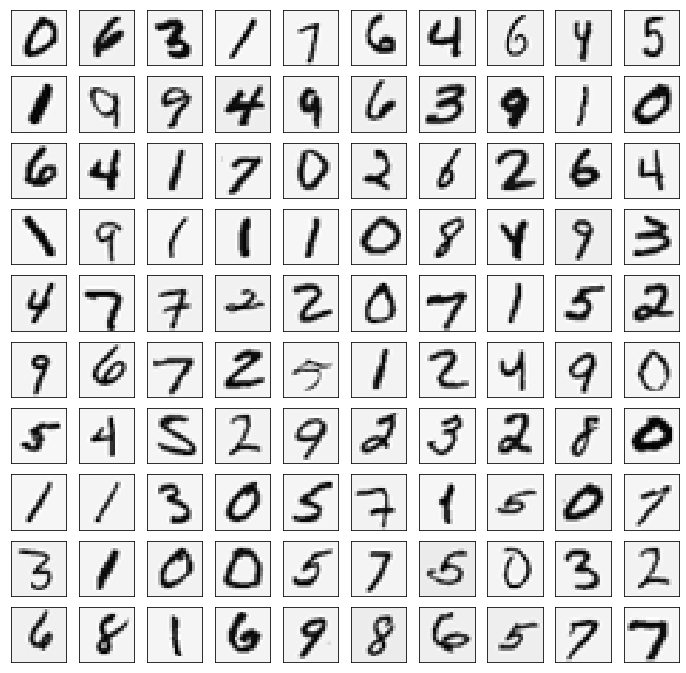

In [5]:
fig,ax_array=plt.subplots(nrows=10,ncols=10,sharey=True,sharex=True,figsize=(12,12)) #设为True或‘all’时，所有子图共享 x 轴或者 y 轴
for r in range(10):
    for c in range(10):
        ax_array[r,c].matshow(np.array(sample_images[10*r+c].reshape((20,20))).T,cmap=matplotlib.cm.binary) #取1-100的所有图片
        plt.xticks(np.array([])) #x轴的刻度(tick)内容的范围
        plt.yticks(np.array([])) #去除刻度，美观

#### 1.3 将逻辑回归向量化
你将用多分类逻辑回归做一个分类器。因为现在有10个数字类别，所以你需要训练10个不同的逻辑回归分类器。
为了让训练效率更高，将逻辑回归向量化是非常重要的，不要用循环。

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) #正则化
    return np.sum(first - second) / len(X) + reg

In [8]:
#向量化正则化逻辑回归
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X) #θ0不正则化
    
    return np.array(grad).ravel()

#### 一对多分类器

In [9]:
#把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k*(n + 1)数组，其中n是参数数量
from scipy.optimize import minimize #非线性优化

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0] #行数
    params = X.shape[1] #列数（参数）

    all_theta = np.zeros((num_labels, params + 1)) #返回来一个给定形状和类型的用0填充的数组；k * (n + 1)
    
    X = np.insert(X, 0, values=np.ones(rows), axis=1) #insert插入元素,axis选行列；ones()返回全1;在X第一列前插入全为1的列向量作常数项 


    for i in range(1, num_labels + 1):
        the = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y]) #对于y，若将某个类别i拿出来之后剩下的类别构成一类
        y_i = np.reshape(y_i,(rows,1)) #按列排放
        
#最小化目标函数，fun:求最小值的目标函数；x0:变量的初始猜测值；args:常数值；
#method:求极值的方法，计算误差，反向传播的方式不同，（TNC：截断牛顿法）；jac：该参数就是计算梯度的函数
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)

        all_theta[i-1,:] = fmin.x #返回使目标函数最小化的x值
    
    return all_theta

In [10]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape,np.unique(data['y']) #unique去除数组中的重复数字，进行排序之后输出;检查y中的类标签

((5000, 401),
 (5000, 1),
 (401,),
 (10, 401),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

In [11]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta.shape

(10, 401)

In [12]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0] #10类
    
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    h = sigmoid(X * all_theta.T) #计算每个训练实例上每个类的类概率
    
    h_argmax = np.argmax(h, axis=1) #创建概率最大的索引数组，argmax用于返回一个数组中最大值的索引值
    
    h_argmax = h_argmax + 1 #因为数组是0-9索引的，所以需要加1来预测真实的标签1-10
    
    return h_argmax

In [13]:
y_pred = predict_all(data['X'], all_theta)
print(classification_report(data['y'], y_pred)) 
#classification_report（y_true，y_pred）用于显示主要分类指标的文本报告-每个类的精确度，召回率，F1值等信息，support为每个标签出现的次数

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 8 神经网络
在前面一个部分，我们已经实现了多分类逻辑回归来识别手写数字。但是，逻辑回归并不能承载更复杂的假设，因为它就是个线性分类器。
这部分，需要实现一个可以识别手写数字的神经网络。神经网络可以表示一些非线性复杂的模型。
权重已经预先训练好，目标是在现有权重基础上，实现前馈神经网络（FNN）。

输入是图片的像素值，20*20像素的图片有400个输入层单元，不包括需要额外添加常数项。
材料已经提供了训练好的神经网络的参数Θ1,Θ2，有25个隐层单元和10个输出单元（10个输出）

In [14]:
weight = loadmat("Coursera-ML-using-matlab-python-master/ex3weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape #25个隐层单元和10个输出单元

((25, 401), (10, 26))

In [15]:
# 插入常数项
X2 = np.matrix(np.insert(data['X'], 0, values=np.ones(X.shape[0]), axis=1))
y2 = np.matrix(data['y'])
X.shape,X2.shape, y2.shape

((5000, 401), (5000, 401), (5000, 1))

In [16]:
a1 = X2
z2 = a1 * theta1.T
a2 = sigmoid(z2)
z2.shape,a2.shape

((5000, 25), (5000, 25))

In [17]:
a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
z3 = a2 * theta2.T
z3.shape

(5000, 10)

In [18]:
a3 = sigmoid(z3)
a3

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [19]:
y_pred2 = np.argmax(a3, axis=1) +1
y_pred2.shape

(5000, 1)

In [20]:
print(classification_report(y2, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

